In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.pyplot as plt

FMO Complex

In [2]:
H = [
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
]
H_fmo= np.pad(H, ((0, 3), (0, 3)), mode='constant')

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(L_temp)
Llist_f_padded = [np.pad(matrix, ((0, 3), (0, 3)), mode='constant') for matrix in Llist_f]

#initial state
u0_fmo = np.zeros(8,dtype=np.complex_)
u0_fmo[1] = 1

In [3]:
# Parallel execution of trajectories
def run_trajectories(num_trajectory, H, ansatz, tf, dt):
    # Create a list of tuples with the required parameters for each trajectory
    param_list = [(H, ansatz, tf, dt) for _ in range(num_trajectory)]
    
    with Pool() as pool:
        results = pool.starmap(solve_avq_trajectory, param_list)
    
    return results


In [4]:
from qmad.solver import solve_avq_trajectory
from qmad.effh import EffectiveHamiltonian
from qmad.ansatz import Ansatz
# Guard for multiprocessing in Jupyter
if __name__ == "__main__":
    # Define your parameters (these are placeholders)
    tf = 450
    dt = 5
    num_trajectory = 400
    H = EffectiveHamiltonian([H_fmo], [Llist_f_padded])
    ansatz = Ansatz(u0_fmo, relrcut=1e-5)

    # Running the parallel trajectories
    results = run_trajectories(num_trajectory, H, ansatz, tf, dt)


In [5]:
Mexp_f = [
    np.diag([0, 1, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 1, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 1, 0,0,0,0]),
    np.diag([1, 0, 0, 0, 0,0,0,0]),
    np.diag([0, 0, 0, 0, 1,0,0,0])
]

# Storage for accumulating the expectation values to compute the average
average_expectation_values = []

# Loop over each trajectory
for j in range(0, num_trajectory):
    # Loop over each observable
    for k, observable in enumerate(Mexp_f):
        expectation_values = []
        
        # Calculate expectation values for the current observable
        for i, psi in enumerate(results[j].psi):
            psi_dagger = np.conjugate(psi).T
            rho = np.outer(psi, psi_dagger)  # Calculate the density matrix
            expectation_value = np.trace(np.dot(rho, observable))  # Expectation value
            
            expectation_values.append(expectation_value.real)  # Append the real part of the expectation value
        
        # Store the expectation values for averaging later
        if len(average_expectation_values) <= k:
            average_expectation_values.append(np.array(expectation_values))  # Initialize the list
        else:
            average_expectation_values[k] += np.array(expectation_values)  # Accumulate values

        # Convert time to femtoseconds
        results_t_converted = [t for t in results[0].t]
        
average_expectation_values = [ev / num_trajectory for ev in average_expectation_values]


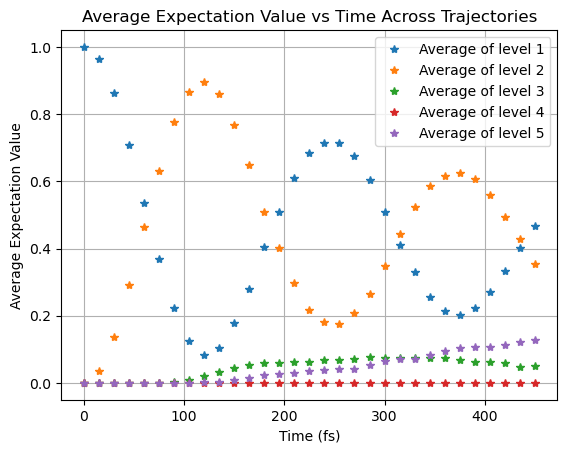

In [6]:

# Plot the average of all the observables
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '*', label=f"Average of level {k+1}")

# Label the plot for the average
plt.xlabel('Time (fs)')
plt.ylabel('Average Expectation Value')
plt.title('Average Expectation Value vs Time Across Trajectories')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from qutip import mesolve, Qobj
import numpy as np
import matplotlib.pyplot as plt
def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

In [10]:
# Hamiltonian
H = Qobj([
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
])

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define the alpha operators
Llist_f = [Qobj(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]

# Define the beta operators
Llist_f += [Qobj(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]

# Define the gamma operator
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(Qobj(L_temp))

psi0_f = Qobj([[0], [1], [0], [0], [0]])
times = np.linspace(0.0, 450.0, 2000)
Mexp_f = [
    Qobj(np.diag([0, 1, 0, 0, 0])),
    Qobj(np.diag([0, 0, 1, 0, 0])),
    Qobj(np.diag([0, 0, 0, 1, 0])),
    Qobj(np.diag([1, 0, 0, 0, 0])),
    Qobj(np.diag([0, 0, 0, 0, 1]))
]
population = qutip_prop(H, psi0_f, times, Llist_f, Mexp_f)


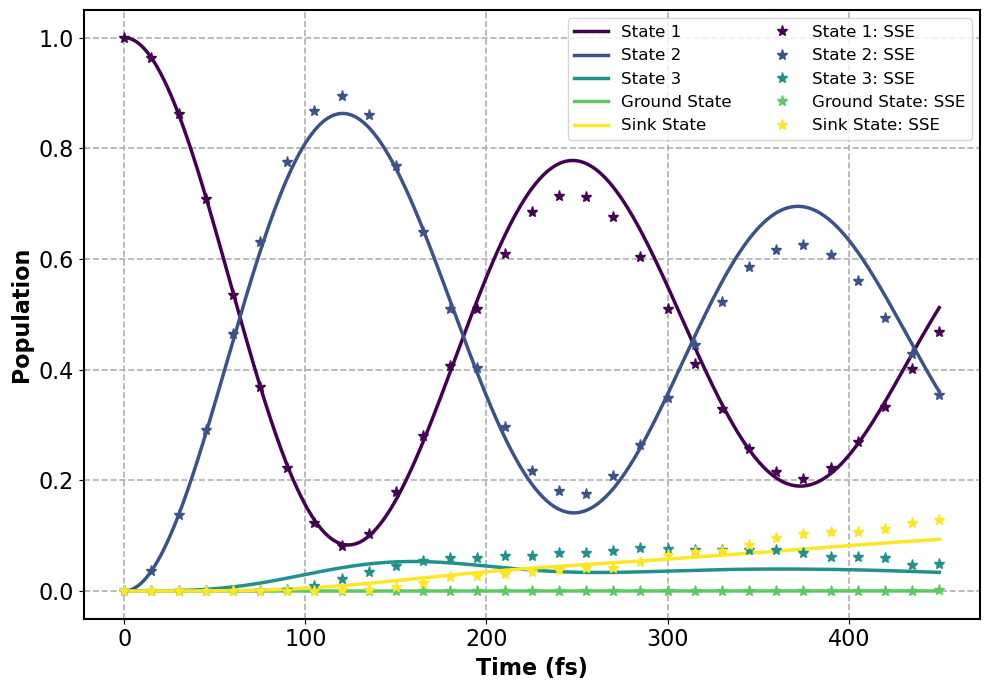

In [11]:
# Plotting the results
plt.figure(figsize=(10, 7))

# Line width and marker size
line_width = 2.5
marker_size = 8

# Define labels for the states
labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]

# Define a colormap for consistent coloring
colors = plt.cm.viridis(np.linspace(0, 1, len(population)))

# Plot for population vs times
for i, (expec, label) in enumerate(zip(population, labels)):
    plt.plot(times, expec, label=label, color=colors[i], linewidth=line_width)

# Plot for average_expectation_values vs results_t_converted
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], 
             '*', color=colors[k], markersize=marker_size, label=f'{labels[k]}: SSE')

# Set labels, title, and grid
plt.xlabel('Time (fs)', fontsize=16, fontweight='bold')
plt.ylabel('Population', fontsize=16, fontweight='bold')
# plt.title('State Populations Over Time', fontsize=16, fontweight='bold')

# Create a combined legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.tick_params(axis='both', which='major', labelsize=16)  # Major ticks

# Set up the horizontal legend at the top right
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right', ncol=2, bbox_to_anchor=(1, 1))

# Make gridlines bolder
plt.grid(True, which='both', linestyle='--', linewidth=1.2)

# Increase the thickness of the plot borders
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("state_populations_horizontal_legend.png", dpi=300)  # Save with high DPI for publication quality
plt.show()
